CAN BE COMPLEXIFIED 

satistical significance 

http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0018961&type=printable

In [1]:
library(RSpectra)

library(igraph)
library(proxy)
library(NMI)

library(topGO)
library(GOSemSim)
library(GOSim)
library(org.Sc.sgd.db)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:igraph’:

    normalize, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, 

In [2]:
module_fitness <- function(community, sample=F) {
    k <- length(community)
    Z_A <- sum(z_score[community]) / sqrt(k)
    if (sample) return (Z_A)
    return((Z_A - means[k]) / standard_deviations[k])
}

community_fitness <- function(A_G, community, alpha) {
    
    # edges in community
#     c <- A_G[community, community]
#     d_in <- sum(c[upper.tri(c, diag = T)])
    
#     # edges out of community
#     d_out <- sum(A_G[!rownames(A_G)%in%community, community])
    
#     if (d_in + d_out == 0){
#         print (community)
#         stop()
#     }
    
#     topological_fitness <- d_in / (d_in + d_out) ** alpha
    active_module_fitness <- module_fitness(community, sample=T) 
#     active_module_fitness <- sum(z_score[community]) / sum(z_score)

    return(active_module_fitness)
}

community_neighbours <- function(A_G, community) {
        
    # nodes not in community
    other_nodes <- rownames(A_G)[!rownames(A_G) %in% community]
        
    # connections to H
    C <- A_G[other_nodes, community]

    # filter C for rows with a connection
    if (class(C) == "matrix") {
        return(rownames(C)[apply(C, 1, function(row) any(row != 0))])             
    } else return(names(C)[C != 0]) # H only contains one node so C is a vector
}
                 
node_fitness <- function(A_G, community, alpha, v) {
    
    # add v to A_H
    community_add <- unique(c(community, v))
    
    # fitness of community with v
    fitness_add <- community_fitness(A_G, community_add, alpha)
    
    # remove v from A_H
    community_remove <- community[community != v]
    
    if (length(community_remove) == 0) 
        fitness_remove <- 0 
    else if (length(community_remove) < 3)    
        fitness_remove <- community_fitness(A_G, community_remove, alpha)
    else {
        
        # fitness of community without v
        # ensure connectedness of subgraph if v is removed
#         H <- induced.subgraph(G, vids = V(G)[V(G)$label %in% community_remove])
        
        H <-A_G[community_remove, community_remove]
        
#         print(A)
#         print(diag(rowSums(A)))
        
        
#         L <- diag(rowSums(H)) - H 
        
#         if (!isSymmetric(L))
#             stop("L is not symmetric")
        
#         print(L)
            
#         res <- eigs_sym(A = L, k = 2, sigma = 0, which = "LM", opts = list(retvec = F))
            
#         print(res)
            
#         print (res$values)
            
#         print (res$values[1])
        
        if (!is_connected(graph_from_adjacency_matrix(H)))
#         if (res$values[1] < 1e-12)
            fitness_remove <- 0
        else
            fitness_remove <- community_fitness(A_G, community_remove, alpha)
        
#         if (is_connected(H)) {
#             fitness_remove <- community_fitness(A_G, community_remove, alpha)
#         } else {
#             components <- components(H)
#             largest_component <- V(H)[components$membership == which.max(components$csize)]
#             fitness_remove <- community_fitness(A_G, community_remove[largest_component], alpha)
#         }    
#         fitness_remove <- community_fitness(A_G, community_remove, alpha)
    }  
    return(fitness_add - fitness_remove)
}
    
probabilistic_neighbour_selection <- function(neighbour_fitnesses, random=F) {
    
    # return best neighbour
    if (!random) return(names(neighbour_fitnesses)[which.max(neighbour_fitnesses)])
        
    # compute probability of selection
    probs <- neighbour_fitnesses
    probs[probs < 0] <- 0
    probs <- probs / sum(probs)
        
#     print(probs)
        
    return(sample(names(probs), 1, prob = probs))
    
}

In [3]:
greedy_community_search <- function(A_G, alpha=1.0, max_iter=100, 
                                    overlaps_allowed=TRUE, consider_disconnected_nodes=FALSE, min_community_size=3) {
    
    # initialise list of communities dicovered
    communities <- list()
    # discard isolated nodes
    if (!consider_disconnected_nodes)
        connected_nodes <- rownames(A_G)[apply(A_G, 1, function(row) any(row > 0))]
    else 
        connected_nodes <- rownames(A_G)
    # vector of whether each node has been asigned to at least one community
    node_assigned <- rep(FALSE, length(connected_nodes))
    names(node_assigned) <- connected_nodes
    # proceed until all nodes are assgined or enough communities have been found
    iter <- 1    
    while (!all(node_assigned) && iter < max_iter) {
        
        #select random seed node from uncovered nodes
        v <- sample(connected_nodes[!node_assigned], 1)
        
        # mark as assigned
        node_assigned[v] <- TRUE

        # initialise community with seed node
        community <- v
        
        # neighbours of community
        neighbours <- community_neighbours(A_G, community)

        # continue until no neiughbours can be found
        while(length(neighbours) > 0) {
            
            # calculate fitness of neighbours
            neighbour_fitnesses <- sapply(neighbours, 
                                          function(neighbour) node_fitness(A_G, community, alpha, neighbour))
            names(neighbour_fitnesses) <- neighbours
                                              
              tryCatch({
                  if (max(neighbour_fitnesses) > 0) {
                      
                  }
              }, error = function(e){
                  print(neighbour_fitnesses)
                  print(neighbours)
                  print(community)
                  stop()
              })

            # add best neighbour to H
            if (max(neighbour_fitnesses) > 0) {
                
                # determine best neighbour
#                 best_neighbour <- names(neighbour_fitnesses)[which.max(neighbour_fitnesses)]
                chosen_neighbour <- probabilistic_neighbour_selection(neighbour_fitnesses, random = T)
                # add ot community
                community <- c(community, chosen_neighbour)
                
#                 print("ADDING TO COMMUNITY")
#                 print(community)
                
            } else break # no neighbour has positive fitness 
                
            # continuously evaluate fitness of all nodes in H and remove nodes with negative fitness
            node_fitnesses <- sapply(community, function(v) node_fitness(A_G, community, alpha, v)) 

            while (any(node_fitnesses < 0)){
                
#                 print("REMOVING NODES")
#                 print(node_fitnesses)
#                 print(community[node_fitnesses<0])
                
                # remove all nodes with negative fitness
                community <- community[node_fitnesses >= 0]

                # break if only one node
#                 if (length(rownames(A_H)) == 1) break
                    
                # recalulate node fitnesses    
                node_fitnesses <- sapply(community, function(v) node_fitness(A_G, community, alpha, v)) 
                
            } 
                    
            # neighbours of community
            neighbours <- community_neighbours(A_G, community)

        }
                    
        # check that community is not a subset of another discovered community
        subset <- any(sapply(communities, function(com) 
            length(intersect(com, community)) == length(community)))
            
        # ensure community is large enough
        if (!subset && length(community) > min_community_size){
            
            # check that community is not super set of another discovered community (keep largest community)
            if (length(communities) > 0) {
                
                superset <- which(sapply(communities, function(com)
                length(intersect(com, community)) == length(com)))
                
                # remove all communities that are subsets of this community
                if (length(superset > 0)) 
                    communities <- communities[-superset]
                
            }
            

            # assign all nodes in A_H to this community
            communities <- c(communities, list(community))

            # mark each node in this community as assigned
            node_assigned[community] <- TRUE

            if (!overlaps_allowed) {
                # remove community from network
                nodes_to_keep <- rownames(A_G)[!rownames(A_G)%in%community]
                A_G <- A_G[nodes_to_keep, nodes_to_keep]
                if (is.null(dim(A_G)))
                    A_G <- matrix(A_G)
                rownames(A_G) <- nodes_to_keep
                colnames(A_G) <- nodes_to_keep
            }           
        }
                    
        # increment iteration
        iter  <- iter + 1
    } 
                                         
    if (iter == max_iter) print("MAXIMIUM ITERATIONS RUN")
    if (all(node_assigned)) print("ALL NODES ASSIGNED")
                                         
    #return community list
    return(communities)
}



In [4]:
increment_consensus_matrix <- function(consensus_matrix, community_list) {

    # iterate over list of communities
    for (community in community_list) {
        
        if(length(community) == 0) next
            
        # iterate over pairs of nodes and increase the pairwise weight in consensus matrix
        for (i in 1:length(community)) {
            n_1 <- community[i]
            for (j in i:length(community)) {
                if (i == j) next
                n_2 <- community[j] 
                    
                # increment consensus matrix
                consensus_matrix[n_1, n_2] <- consensus_matrix[n_1, n_2] + 1
                consensus_matrix[n_2, n_1] <- consensus_matrix[n_2, n_1] + 1                
            }
        }
    } 
        
    return(consensus_matrix)
    
}

In [5]:
adjacency_matrix_to_consensus_matrix <- function(A_G, alpha=1.0, 
                                                 num_repeats=100, max_iter=100, 
                                                 overlaps_allowed=TRUE, normalise=FALSE, filter="50%") {
    
    # run algorithm num_repeats times
    community_assignments <- lapply(1:num_repeats, function(i) 
        greedy_community_search(A_G, alpha=alpha, max_iter=max_iter, overlaps_allowed=overlaps_allowed))
    
    # convert to consensus matrix
    # initialise consensus matrix
    consensus_matrix <- matrix(0, nrow=nrow(A_G), ncol=ncol(A_G))
    rownames(consensus_matrix) <- rownames(A_G)
    colnames(consensus_matrix) <- colnames(A_G)
    
    # update consensus matrix
    for (community_assignment in community_assignments) {
        consensus_matrix <- increment_consensus_matrix(consensus_matrix, community_assignment)
    }
        
    # normalisation 
    if (normalise) {
        consensus_matrix <- consensus_matrix / num_repeats
    }    
    
    # filter consensus matrix
    consensus_matrix[consensus_matrix < quantile(consensus_matrix)[filter]] <- 0
        
    return(consensus_matrix)
}

In [6]:
matrix_multiply <- function(M, n) {
    if (n==0) return(diag(nrow=nrow(M)))
    return(M%*%matrix_multiply(M, n-1))
}

In [7]:
random_module_sample <- function(A_G, k) {
    
    module <- sample(rownames(A_G), 1)
    
    while (length(module) < k) {
        
        neighbours <- community_neighbours(A_G, module)
        
        while (length(neighbours) == 0) {
            module <- sample(rownames(A_G), 1)
            neighbours <- community_neighbours(A_G, module)
        }
        
        module <- c(module, sample(neighbours, 1))
        
    }
    
    return(module_fitness(module, sample=T))
    
}

In [8]:
precompute_random_sample_fitnesses <- function(A_G, num_repeats=10, k=20) {
    return(sapply(1:num_repeats, function(r)
        sapply(1:k, function(ki) random_module_sample(A_G, ki))))
}

In [9]:
# read in graph
# df <- read.table("biogrid_edgelist.txt")
# G <- graph.data.frame(df, directed = F)
G <- read.graph("galFiltered.gml", "gml")
# G <- read.graph("reactome_edgelist.txt", format = "ncol", directed = F)
# G <- simplify(G)

In [10]:
expressions <- read.table("galExpData.csv", sep = ",", header = T)

p_values <- expressions[,"gal1RGsig"]
names(p_values) <- expressions[,"GENE"]

z_score <- qnorm(1 - p_values)

genes <- V(G)$label[V(G)$label%in%names(z_score)]

z_score <- z_score[genes]

In [11]:
A_G <- as.matrix(as_adj(G))
rownames(A_G) <- V(G)$label
colnames(A_G) <- V(G)$label

# make symmetric 
for (i in 1:nrow(A_G)) {
    for (j in i:ncol(A_G)){
        m <- max(A_G[i, j], A_G[j, i])
        A_G[i, j] <- m
        A_G[j, i] <- m
    }
}

A_G <- A_G[genes, genes]

In [84]:
# D <- diag(1/igraph::degree(G, mode="all"))
# rownames(D) <- V(G)$label
# colnames(D) <- V(G)$label

# D <- D[genes, genes]

In [85]:
# L <- as.matrix(laplacian_matrix(G))
# rownames(L) <- V(G)$label
# colnames(L) <- V(G)$label

# L <- L[genes, genes]

In [86]:
# walk matrix
# W <- 0.5 * diag(nrow(A)) + 0.5 * A %*% D

In [87]:
# # weight by similarity
# S1 <- A
# # S2 <- 1 - as.matrix(dist(S1, method = "cosine"))
# S2 <- 0

# # weighting of second order similarity
# w1 <- 0

# # create weighted adjacancy matrix
# A_G <- S1 + w1 * S2
# rownames(A_G) <- V(G)$label
# colnames(A_G) <- V(G)$label

# normalise similarity matrix
# A_G <- A_G / max(A_G)

In [88]:
# # filter out nodes with no annotations
# nodes_to_keep <- rownames(A_G)[rownames(A_G) %in% names(z_score)]

# # multiply by expression values (hadamand product)
# A_G <- A_G[nodes_to_keep, nodes_to_keep] * Z[nodes_to_keep, nodes_to_keep]

# # normalise A_G
# A_G <- A_G / max(A_G)

In [12]:
mean_file <- "means.rda"
sd_file <- "sd.rda"

if (!file.exists(mean_file)) {
    
    k <- 100

    sample_fitnesses <- precompute_random_sample_fitnesses(A_G, num_repeats = 30, k = k)
    means <- apply(sample_fitnesses, 1, mean)
    names(means) <- 1:k
    standard_deviations <- apply(sample_fitnesses, 1, sd)
    names(standard_deviations) <- 1:k
    
    save(means, file=mean_file)
    save(standard_deviations, file=sd_file)
    print("saved files")
    
} else {
    load(mean_file)
    load(sd_file)
    print("loaded files")
}

[1] "loaded files"


In [13]:
# resolution parameter(s)
alphas <- c(1.0)

# number of repeats
num_repeats <- 10

# number of iterations
num_iter <- 1

# filtering
tau <- 0.1

# weight decay
lambda <- 0

# convert to consensus matrix
consensus_matrix <- A_G 

In [91]:
# consensus_matrix <- adjacency_matrix_to_consensus_matrix(consensus_matrix, alpha=1.0, 
#                                              num_repeats = 10, max_iter = 100, overlaps_allowed = T, 
#                                              normalise = T, filter="75%")   

In [35]:
# for (iter in 1:num_iter) {
    
#     # obtain consensus matrix for each resolution
#     multi_scale_consensus_matrices <- lapply(alphas, function(alpha)
#         adjacency_matrix_to_consensus_matrix(consensus_matrix, alpha=alpha, 
#                                              num_repeats = num_repeats, max_iter = 100, overlaps_allowed = T, 
#                                              normalise = T, filter="0%"))   
        
#     # initialise consensus matrix
#     c_m <- matrix(0, nrow=nrow(A_G), ncol=ncol(A_G))
#     rownames(c_m) <- rownames(A_G)
#     colnames(c_m) <- colnames(A_G)
        
#     # sum consensus matrices for all scales
#     for (mat in multi_scale_consensus_matrices) {
#         c_m <- c_m + mat
#     }
        
#     # normalise consensus matrix
#     c_m  <- c_m / length(alphas)

#     # update consensus matrix
#     consensus_matrix <- lambda * consensus_matrix + (1 - lambda) * c_m
# }

In [92]:
# heatmap(consensus_matrix)

In [14]:
# cluster based on consensus matrix
communities <- greedy_community_search(consensus_matrix, max_iter = 1000, 
                                       alpha = 1.0, overlaps_allowed = T, min_community_size = 3)

[1] "ALL NODES ASSIGNED"


In [15]:
coms <- 1:length(communities)
names(communities) <- coms

# invert (for NMI)
assignments <- numeric(length = length(V(G)))
names(assignments) <- V(G)$label
for (i in 1:length(communities)) {
    for (node in communities[[i]]) {
        assignments[node] <- i
    }
}

# assignments <- assignments[names(assignments) %in% keys(org.Sc.sgd.db)]

In [16]:
communities

$`1`
 [1] "YIL061C" "YDL013W" "YMR044W" "YNL199C" "YPL075W" "YGR254W" "YAL038W"
 [8] "YDR050C" "YHR174W" "YDL030W" "YCR012W" "YMR005W" "YNR053C" "YJR060W"
[15] "YOL086C"

$`2`
[1] "YLR258W" "YGL134W" "YPL031C" "YHR071W"

$`3`
[1] "YGL153W" "YDR244W" "YLR191W" "YDL078C" "YDR142C" "YIL160C"

$`4`
[1] "YDL215C" "YLR432W" "YDR167W" "YML114C"

$`5`
 [1] "YOR036W" "YPL240C" "YBL050W" "YGR009C" "YLR362W" "YOR212W" "YLL021W"
 [8] "YOR327C" "YMR183C" "YJL157C" "YHR030C" "YMR043W" "YPR119W" "YGR108W"
[15] "YGL008C" "YDR461W" "YER111C" "YKR097W" "YPR113W" "YNL145W" "YER143W"
[22] "YJL159W" "YDR146C" "YDL023C" "YGL035C" "YIL113W" "YLL019C" "YLR044C"
[29] "YFL026W" "YIL162W" "YBR020W" "YER124C" "YIL015W" "YLR377C" "YER179W"
[36] "YBL069W" "YLR134W" "YIL105C" "YCL067C" "YOL051W" "YBR018C" "YLR081W"
[43] "YCL032W" "YNL047C" "YBR135W" "YER102W" "YFL017C" "YOL059W" "YDR070C"
[50] "YDR009W" "YHR084W"

$`6`
[1] "YML032C" "YAR007C" "YPL111W" "YNL189W" "YER065C" "YOL058W" "YDL236W"

$`7`
 [1] "YML123C" "YBR093C" "YNL216W" "YIL133C" "YDR171W" "YOL120C" "YML024W"
 [8] "YGR254W" "YHR174W" "YOL086C" "YDR050C" "YPL075W" "YAL038W" "YFR034C"
[15] "YCR012W" "YIL069C" "YCL030C" "YLR044C" "YNL301C" "YER074W" "YGL035C"
[22] "YBR020W" "YIL162W" "YOL127W" "YLR377C" "YKR099W" "YDR146C" "YJR060W"
[29] "YER179W" "YOL051W" "YIL105C" "YLR134W" "YLR081W" "YNL199C" "YBR018C"
[36] "YNL047C" "YMR043W" "YER111C" "YFL026W" "YJL159W" "YKR097W" "YPR119W"
[43] "YDR461W" "YGL008C" "YPR113W" "YCL067C" "YJL157C" "YBL069W" "YHR030C"
[50] "YNL145W" "YDL023C" "YIL015W" "YGR108W" "YLL021W" "YOR212W" "YBR135W"
[57] "YER102W" "YFL017C" "YOL059W" "YDR070C" "YIL113W" "YLL019C"

$`8`
 [1] "YGR085C" "YLR075W" "YDR395W" "YPR102C" "YIL052C" "YIL133C" "YNL069C"
 [8] "YNL216W" "YCR012W" "YOL120C" "YDR050C" "YML024W" "YDR171W" "YAL038W"
[15] "YHR174W" "YLR044C" "YJR060W" "YDL075W" "YOL127W" "YGL035C" "YPL075W"
[22] "YCL030C" "YLR377C" "YBR093C" "YBR020W" "YIL069C" "YER179W" "YLR134W"
[29] "YNL199C" "YGR254W" "YIL162W" "YKR099W" "YNL301C" "YOL051W" "YDR146C"
[36] "YLR081W" "YER074W" "YIL105C" "YBR018C" "YNL047C" "YMR043W" "YDR461W"
[43] "YKR097W" "YJL157C" "YPR113W" "YFL026W" "YOL086C" "YIL015W" "YNL145W"
[50] "YGR108W" "YJL159W" "YOR212W" "YDL023C" "YCL067C" "YER111C" "YPR119W"
[57] "YGL008C" "YBL069W" "YBR135W" "YHR030C" "YLL021W" "YIL113W" "YER102W"
[64] "YLL019C" "YFL017C" "YOL059W" "YDR070C"

$`9`
[1] "YKR026C" "YGL122C" "YOL123W" "YMR255W" "YGL044C"

$`10`
[1] "YOR178C" "YBR045C" "YGL073W" "YBR072W" "YHR055C" "YER103W" "YHR053C"

$`11`
[1] "YER112W" "YLR264W" "YOL149W" "YOR167C"

$`12`
 [1] "YJR048W" "YGL237C" "YKL109W" "YGL035C" "YLR044C" "YDR146C" "YBR020W"
 [8] "YLR377C" "YIL162W" "YOL051W" "YER179W" "YIL105C" "YLR134W" "YLR081W"
[15] "YMR043W" "YFL026W" "YPR113W" "YJL157C" "YGR108W" "YER111C" "YIL015W"
[22] "YKR097W" "YNL145W" "YGL008C" "YNL047C" "YDR461W" "YPR119W" "YBL069W"
[29] "YHR030C" "YBR018C" "YJL159W" "YDL023C" "YLL021W" "YIL113W" "YOR212W"
[36] "YLL019C" "YCL067C" "YBR135W" "YER102W" "YFL017C" "YDR070C" "YOL059W"
[43] "YDR009W" "YHR084W"

$`13`
[1] "YCL040W" "YFL039C" "YHR179W" "YDR382W" "YDL130W"

$`14`
[1] "YPL211W" "YGR014W" "YJL013C" "YGL229C"

$`15`
[1] "YFR014C" "YOR326W" "YGL106W" "YBR109C" "YOL016C"

In [17]:
lengths(communities)

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 
15  4  6  4 51  7 62 67  5  7  4 44  5  4  5

In [18]:
module_scores <- sapply(communities, function(com) module_fitness(com, sample=T))
module_scores

1         2         3         4         5         6         7         8 
17.323597  8.659363  9.055177  8.141907 30.295831  9.371754 35.901709 36.954750 
        9        10        11        12        13        14        15 
 7.614397  9.742729  7.846464 28.735029  8.785302  5.561297  9.360113

In [19]:
corrected_module_scores <- sapply(communities, function(com) module_fitness(com, sample=F))
corrected_module_scores

1.15         2.4         3.6         4.4        5.51         6.7 
 1.77947271  1.41631132  1.06667268  1.17370647  2.52367713  0.53115932 
       7.62        8.67         9.5        10.7        11.4       12.44 
 4.20312032  4.88867401  0.20144825  0.71295668  1.03519066  2.86863761 
       13.5        14.4        15.5 
 0.69097959 -0.03618941  0.93129626

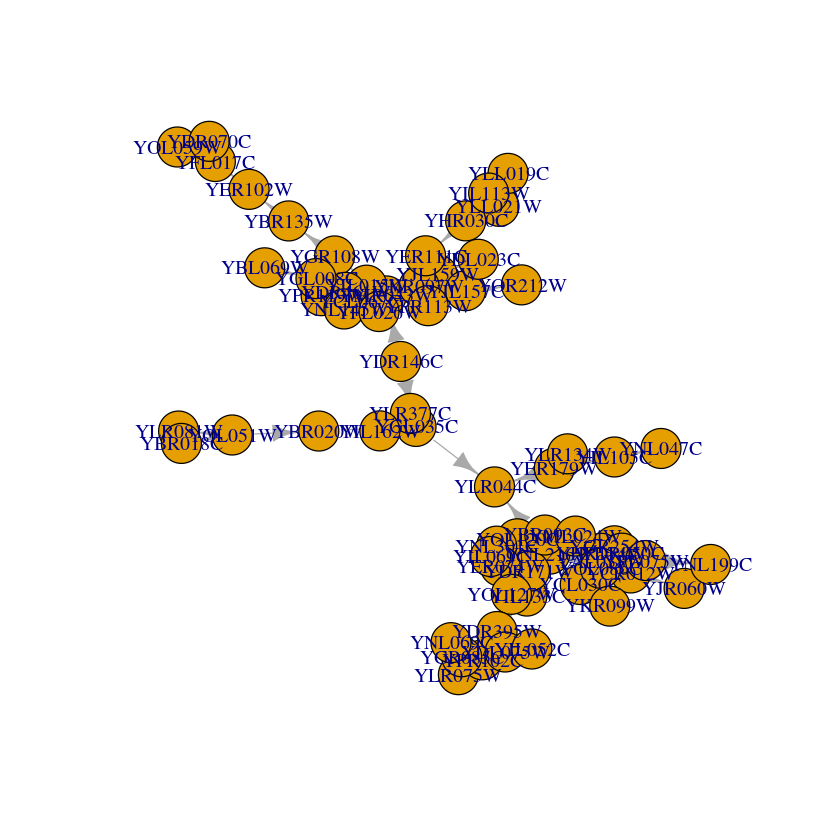

In [20]:
nodes_to_plot <- V(G)[V(G)$label %in% communities[[which.max(corrected_module_scores)]]]
plot.igraph(induced.subgraph(G, vids = nodes_to_plot),
            
#            vertex.size=z_score[V(G)[nodes_to_plot]$label], 
           edge.label=NA,
           vertex.color=factor(V(G)[nodes_to_plot]$label == "YML051W"))

In [22]:
write(communities[[which.max(corrected_module_scores)]], "best_active_module.txt")

In [40]:
# count intercommunity edges
inter_community_edges <- function(A_G, c1, c2) {
    return(sum(A_G[c1, c2]))
}

In [41]:
edges <- sapply(coms, function(i) sapply(coms, function(j) {
        if(i == j) return (0)
        inter_community_edges(A_G, communities[[i]], communities[[j]])
    }))
rownames(edges) <- coms
colnames(edges) <- coms

In [42]:
sum(edges)

[1] 2110

In [184]:
# true_df <- data.frame(node_id=V(G)$id, module=V(G)$club)
# pred_df <- data.frame(node_id=V(G)$id, module=assignments)
# NMI(true_df, pred_df)$value

[1] 0.693611

## GO Term Enrichment

In [43]:
# prepare godata object for cluster functional similarity
scGO <- godata(OrgDb = "org.Sc.sgd.db", keytype = "ORF", ont = "BP")

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [44]:
# filter out genes not in database
orfCommunities <- sapply(communities, function(com) com[com%in%keys(org.Sc.sgd.db)])

In [45]:
# compute functional similarity of communities
clusterSim <- mclusterSim(orfCommunities, semData = scGO)
rownames(clusterSim) <- coms
colnames(clusterSim) <- coms
diag(clusterSim) <- 0

# filter out < 0.5
clusterSim[clusterSim < 0.5] <- 0

In [46]:
I <- graph_from_adjacency_matrix(clusterSim, mode = "undirected", weighted = T)

In [16]:
# cluster network based on GO similairity
# go_communities <- greedy_community_search(clusterSim,
#                                           max_iter = 100, alpha=1.0, 
#                                           overlaps_allowed = F, min_community_size=0)

ERROR: Error in apply(A_G, 1, function(row) any(row > 0)): dim(X) must have a positive length


In [47]:
go_communities <- components(I)$membership

In [50]:
go_communities

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 
 1  2  3  2  2  4  2  3  5  2  2  6  7  2  2  1

In [37]:
# go_assignments <- go_assignments[rev(order(lengths(go_assignments)))]

In [48]:
# # reverse
# go_assignments <- numeric(length = length(communities))
# names(go_assignments) <- coms
# for (i in 1:length(go_communities)) {
#     for (com in go_communities[[i]]) {
#         go_assignments[com] <- i
#     }
# }
# go_assignments_ <- components(I)$membership

In [49]:
# go_assignments

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 
16 15  8  6  9 12 13  0  0  0  0  0  0  0  0  0

In [52]:
colors <- rainbow(max(go_communities))
names(colors) <- 1:max(go_communities)

In [53]:
colors

1           2           3           4           5           6 
"#FF0000FF" "#FFDB00FF" "#49FF00FF" "#00FF92FF" "#0092FFFF" "#4900FFFF" 
          7 
"#FF00DBFF"

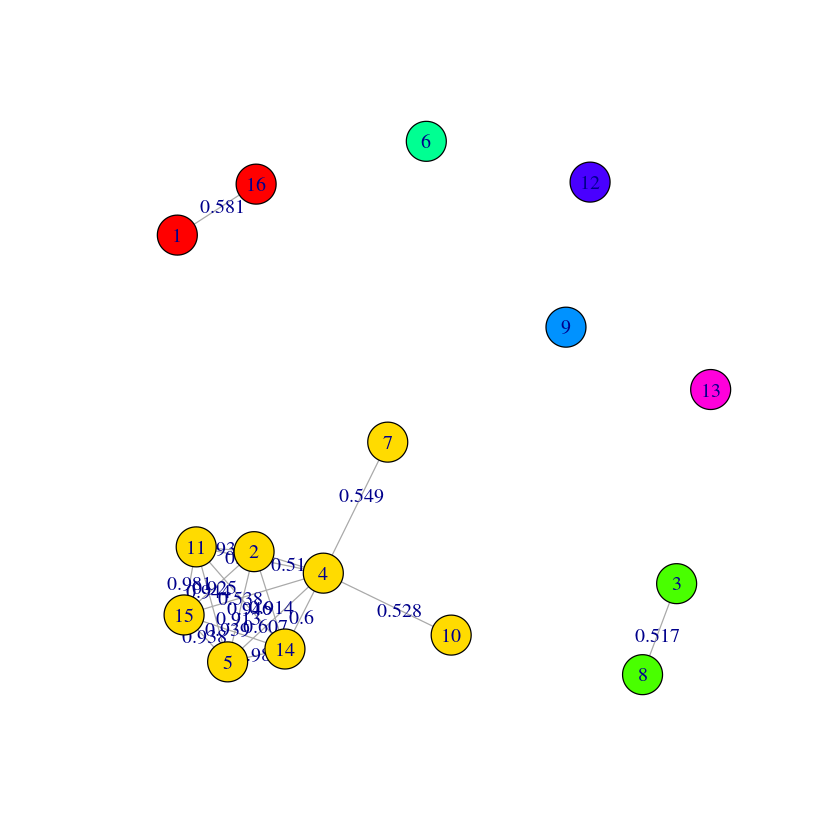

In [55]:
plot.igraph(I, vertex.color=colors[go_communities], edge.label=E(I)$weight)

In [56]:
E <- graph_from_adjacency_matrix(edges, mode = "undirected", weighted = T)

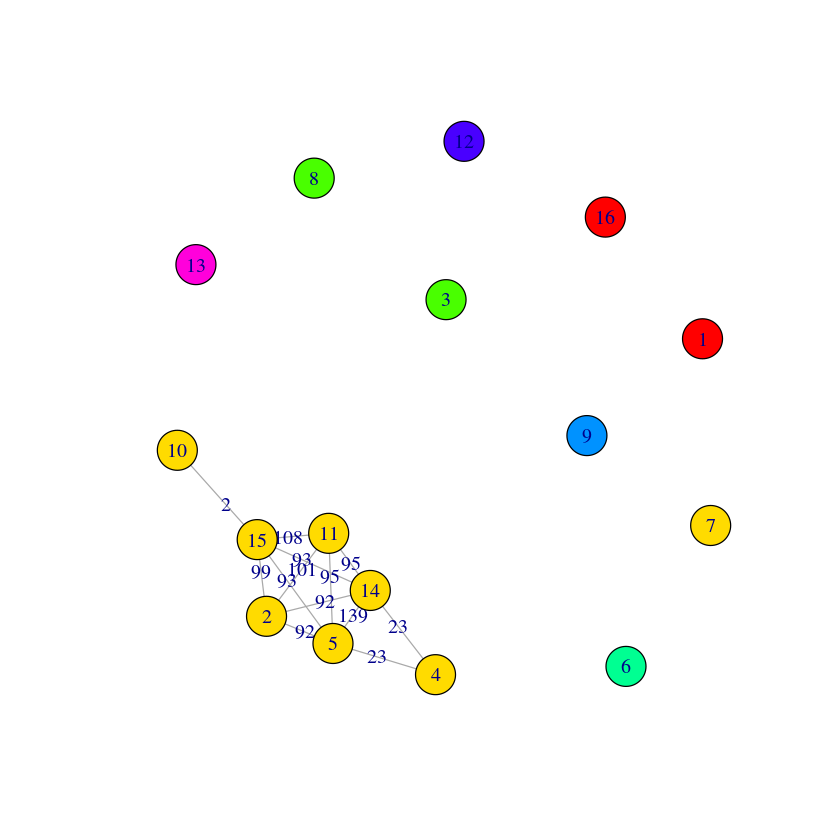

In [60]:
plot.igraph(E, vertex.color=colors[go_communities], edge.label=E(E)$weight)

In [61]:
# plot some communities
communities_of_interest <- c(10, 15, 2)
nodes_of_interest <- unlist(communities[communities_of_interest])

In [62]:
communities_of_interest

[1] 10 15  2

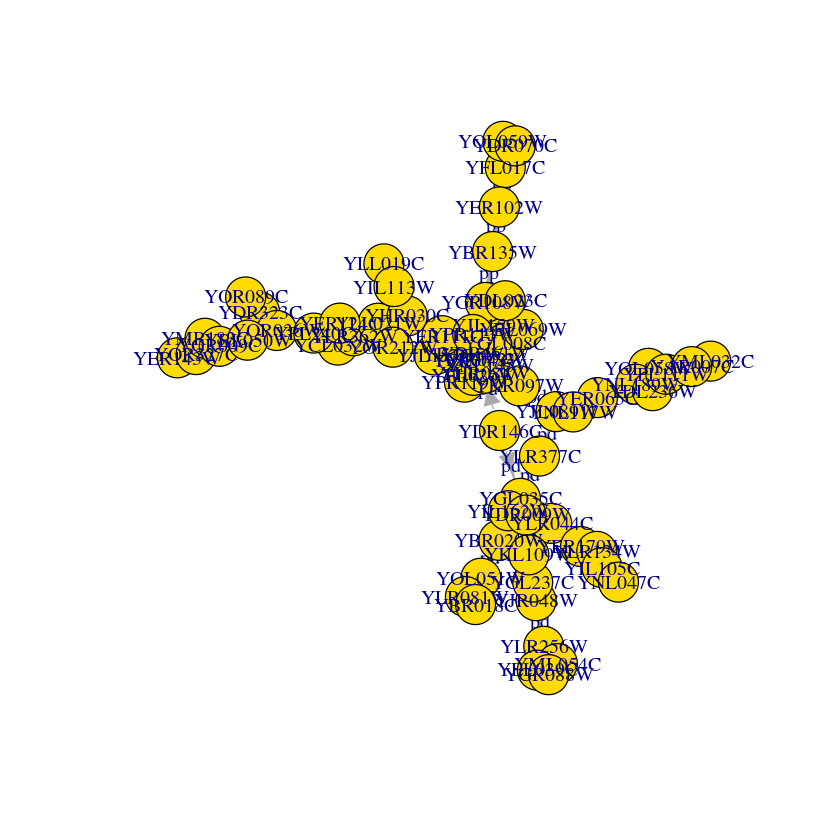

In [66]:
node_ids <- V(G)[V(G)$label %in% nodes_of_interest]
sub_G <- induced.subgraph(graph = G, vids = node_ids)
plot.igraph(sub_G, 
            vertex.color=colors[go_communities[assignments[nodes_of_interest]]],
#             vertex.color=assignments[nodes_of_interest], 
            edge.label=E(sub_G)$weight)

In [68]:
library(ReactomePA)

Loading required package: DOSE
DOSE v3.0.10  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Attaching package: ‘DOSE’

The following objects are masked from ‘package:GOSemSim’:

    clusterSim, geneSim, mclusterSim

ReactomePA v1.18.1  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479


In [80]:
# convert ORFs to EntrezID

conversion_table <- select(org.Sc.sgd.db, keys=keys(org.Sc.sgd.db), keytype="ORF", columns="ENTREZID")
conversion <- conversion_table[,"ENTREZID"]
names(conversion) <- conversion_table[,"ORF"]

conversion <- conversion[!is.na(conversion)]

'select()' returned 1:1 mapping between keys and columns


In [83]:
x <- enrichPathway(gene = conversion[communities[[which.max(corrected_module_scores)]]], organism = "yeast")

In [86]:
df <- as.data.frame(x)

In [88]:
df

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
5719486,5719486,GTP hydrolysis and joining of the 60S ribosomal subunit,14/27,135/1145,2.755923e-07,5.217792e-06,3.635822e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719487,5719487,Formation of a pool of free 40S subunits,14/27,135/1145,2.755923e-07,5.217792e-06,3.635822e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719995,5719995,SRP-dependent cotranslational protein targeting to membrane,14/27,137/1145,3.341326e-07,5.217792e-06,3.635822e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719699,5719699,Peptide chain elongation,14/27,138/1145,3.674501e-07,5.217792e-06,3.635822e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719700,5719700,Eukaryotic Translation Elongation,14/27,138/1145,3.674501e-07,5.217792e-06,3.635822e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719943,5719943,Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC),14/27,142/1145,5.330880e-07,5.671900e-06,3.952251e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719944,5719944,Nonsense-Mediated Decay (NMD),14/27,144/1145,6.390874e-07,5.671900e-06,3.952251e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719945,5719945,Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC),14/27,144/1145,6.390874e-07,5.671900e-06,3.952251e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719697,5719697,L13a-mediated translational silencing of Ceruloplasmin expression,14/27,147/1145,8.341847e-07,5.922711e-06,4.127019e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14
5719698,5719698,3' -UTR-mediated translational regulation,14/27,147/1145,8.341847e-07,5.922711e-06,4.127019e-06,850764/856217/852976/851484/853993/854673/854759/855655/854741/856805/854984/854029/855415/856839,14


In [102]:
translation_genes <- subset(df, Description=="Translation")[,"geneID"]
translation_genes <- strsplit(translation_genes, "/")[[1]]

In [112]:
metabolism_genes <- subset(df, Description=="Metabolism of carbohydrates")[,"geneID"]
metabolism_genes <- strsplit(metabolism_genes, "/")[[1]]

In [113]:
names(conversion)[which(conversion %in% translation_genes)]

[1] "YDL075W" "YER074W" "YER102W" "YGR085C" "YIL052C" "YIL069C" "YIL133C"
 [8] "YLR075W" "YML024W" "YNL069C" "YNL301C" "YOL120C" "YOL127W" "YPR102C"

In [114]:
names(conversion)[which(conversion %in% metabolism_genes)]

[1] "YAL038W" "YBR018C" "YCR012W" "YDR050C" "YGR254W" "YHR174W" "YLR377C"

In [33]:
# initialise GoSim for most representative terms
setEvidenceLevel(organism = org.Sc.sgdORGANISM, evidences = "all", gomap = org.Sc.sgdGO)
setOntology("BP", loadIC = F,)

initializing GOSim package ...
-> retrieving GO information for all available genes for organism 'human' in GO database
-> filtering GO terms according to evidence levels 'all'
-> loading files with information content for corresponding GO category (human)
finished.
-> retrieving GO information for all available genes for organism 'Saccharomyces cerevisiae' in GO database
-> filtering GO terms according to evidence levels 'all'


In [ ]:
# perform GO term enrichment with topGO
goEnrichmentResults <- sapply(orfCommunities, function(com) 
    GOenrichment(genesOfInterest = com, allgenes = keys(org.Sc.sgd.db), cutoff = 0.05))

rownames(goEnrichmentResults) <- c("GO Terms", "p-values", "genes")

go_terms <- goEnrichmentResults["GO Terms",]
pvalues <- goEnrichmentResults["p-values",]
genes <- goEnrichmentResults["genes",]


Building most specific GOs .....
	( 2909 GO terms found. )

Build GO DAG topology ..........
	( 5064 GO terms and 11404 relations. )

Annotating nodes ...............
	( 6419 genes annotated to the GO terms. )

			 -- Elim Algorithm -- 

		 the algorithm is scoring 133 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 11:	2 nodes to be scored	(0 eliminated genes)

	 Level 10:	5 nodes to be scored	(12 eliminated genes)

	 Level 9:	6 nodes to be scored	(12 eliminated genes)

	 Level 8:	8 nodes to be scored	(12 eliminated genes)

	 Level 7:	10 nodes to be scored	(12 eliminated genes)

	 Level 6:	23 nodes to be scored	(12 eliminated genes)

	 Level 5:	31 nodes to be scored	(28 eliminated genes)

	 Level 4:	26 nodes to be scored	(28 eliminated genes)

	 Level 3:	14 nodes to be scored	(28 eliminated genes)

	 Level 2:	7 nodes to be scored	(28 eliminated genes)

	 Level 1:	1 nodes to be scored	(28 eliminated genes)

Building most specific GOs .....
	( 2909

In [60]:
go_gene_clusters <- lapply(1:max(go_assignments_), function(i) 
    unlist(orfCommunities[names(go_assignments_)[go_assignments_ == i]]))

In [63]:
# go term enrichment for go clusters
go_gene_enrichment_clusters <- sapply(go_gene_clusters, function(clust) 
    GOenrichment(genesOfInterest = clust, allgenes = keys(org.Sc.sgd.db), cutoff = 0.05))

rownames(go_gene_enrichment_clusters) <- c("GO Terms", "p-values", "genes")
gene_go_terms <- go_gene_enrichment_clusters["GO Terms",]
gene_pvalues <- go_gene_enrichment_clusters["p-values",]
gene_genes <- go_gene_enrichment_clusters["genes",]


Building most specific GOs .....
	( 2909 GO terms found. )

Build GO DAG topology ..........
	( 5064 GO terms and 11404 relations. )

Annotating nodes ...............
	( 6419 genes annotated to the GO terms. )

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1330 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 16:	2 nodes to be scored	(0 eliminated genes)

	 Level 15:	8 nodes to be scored	(0 eliminated genes)

	 Level 14:	18 nodes to be scored	(0 eliminated genes)

	 Level 13:	37 nodes to be scored	(0 eliminated genes)

	 Level 12:	50 nodes to be scored	(51 eliminated genes)

	 Level 11:	73 nodes to be scored	(104 eliminated genes)

	 Level 10:	115 nodes to be scored	(781 eliminated genes)

	 Level 9:	165 nodes to be scored	(861 eliminated genes)

	 Level 8:	171 nodes to be scored	(960 eliminated genes)

	 Level 7:	181 nodes to be scored	(1069 eliminated genes)

	 Level 6:	198 nodes to be scored	(1158 eliminated genes)

	 Level 5:	159 nodes

In [71]:
get_parent_term <- function(terms) {
    parent_term <- getMinimumSubsumer(terms[1], terms[2])
    
    for (term in terms) {
        parent_term <- getMinimumSubsumer(parent_term, term)
    }
    return(parent_term)
}

In [72]:
most_general_terms <- sapply(gene_pvalues, function(terms) get_parent_term(names(terms)))

In [67]:
most_general_terms <- sapply(gene_pvalues, function(i) names(i)[which.max(i)])

In [68]:
most_general_terms

[1] "GO:1901990" "GO:0043085" "GO:0006995" "GO:0019682" "GO:0034655"

In [78]:
library(ReactomePA)

Loading required package: DOSE
DOSE v3.0.10  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Attaching package: ‘DOSE’

The following objects are masked from ‘package:GOSemSim’:

    clusterSim, geneSim, mclusterSim

ReactomePA v1.18.1  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479


In [79]:
entrez_communities <- sapply(go_gene_clusters, function(orfs) {
    conversion <- select(org.Sc.sgd.db, keys = orfs, columns="ENTREZID")[,"ENTREZID"]
    return(conversion[!is.na(conversion)])
})

'select()' returned many:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [81]:
all_genes_entrez <- select(org.Sc.sgd.db, keys=keys(org.Sc.sgd.db), columns="ENTREZID", keytype="ORF")[,"ENTREZID"]
all_genes_entrez <- all_genes_entrez[!is.na(all_genes_entrez)]

'select()' returned 1:1 mapping between keys and columns


In [82]:
pathway_enrichment_results <- sapply(entrez_communities, function(com)
                                     enrichPathway(gene = com, organism = "yeast", universe = all_genes_entrez))

In [89]:
pathway_enrichment_results

[[1]]
#
# over-representation test
#
#...@organism 	 yeast 
#...@ontology 	 Reactome 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:155] "852122" "851726" "853353" "856852" "851549" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...20 enriched terms found
'data.frame':	20 obs. of  9 variables:
 $ ID         : chr  "5719840" "5719841" "5719523" "5719524" ...
 $ Description: chr  "Regulation of AMPK activity via LKB1" "Energy dependent regulation of mTOR by LKB1-AMPK" "RNA Polymerase II Promoter Escape" "RNA Polymerase II Transcription Initiation And Promoter Clearance" ...
 $ GeneRatio  : chr  "4/29" "4/29" "6/29" "6/29" ...
 $ BgRatio    : chr  "10/1145" "10/1145" "35/1145" "35/1145" ...
 $ pvalue     : num  6.3e-05 6.3e-05 1.5e-04 1.5e-04 1.5e-04 ...
 $ p.adjust   : num  0.0029 0.0029 0.0029 0.0029 0.0029 ...
 $ qvalue     : num  0.0025 0.0025 0.0025 0.0025 0.0025 ...
 $ geneID     : chr  "856749/852664/852088/852763" "856749/852664/852088/852763" "855276/852766/853840/851906/8517

In [69]:
go <- select(GO.db, keys = most_general_terms, columns = c("GOID", "TERM", "DEFINITION"))

'select()' returned 1:1 mapping between keys and columns


In [78]:
graphics.off()

'select()' returned many:1 mapping between keys and columns


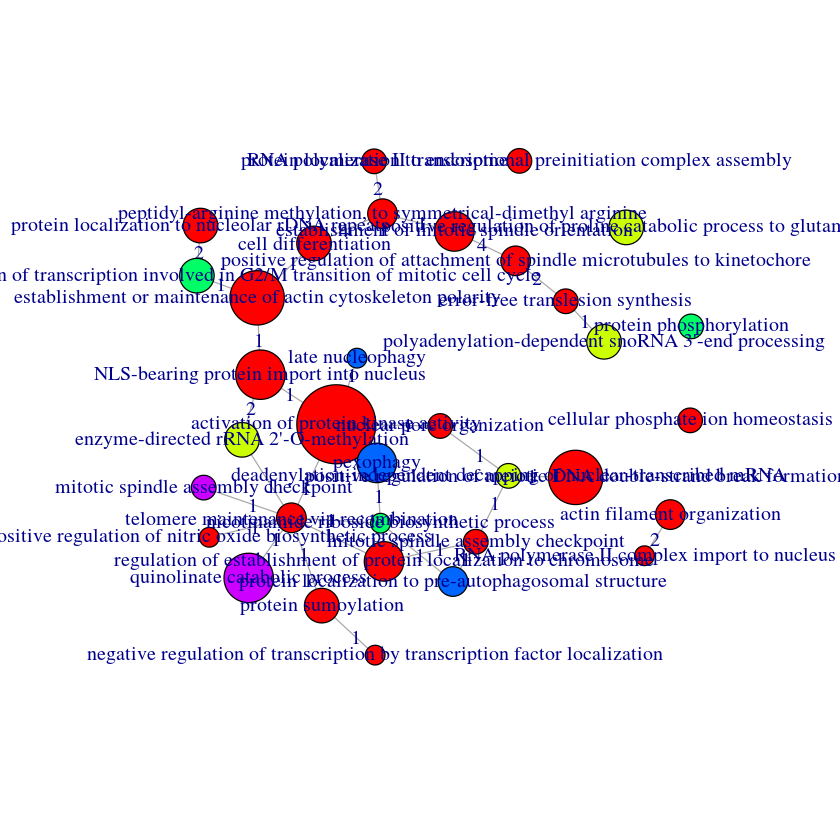

In [85]:
# dev.new(width = 20, height = 20)
plot(E, 
     vertex.label=select(GO.db, 
                keys = sapply(pvalues, function(i) names(i)[which.min(i)]), columns = "TERM")[,"TERM"],
            vertex.size=2*lengths(communities), vertex.color=colors[go_assignments_], edge.label=E(E)$weight)
# legend("bottomleft", legend=go[,"TERM"], col='black', pch=21, pt.bg=colors, text.col=1)

In [90]:
# weight communities by internal edges
diag(edges) <- sapply(communities, function(com) sum(A_G[com, com][upper.tri(A_G[com, com], diag = T)]))

In [140]:
# run again at higher level 
high_order_consensus_matrix <- adjacency_matrix_to_consensus_matrix(edges, overlaps_allowed = T, filter = "0%", normalise = F,
                                                                    alpha = 1.0, num_repeats = 10, max_iter = 1000)

In [141]:
# cluster based on consensus matrix
high_order_communities <- greedy_community_search(high_order_consensus_matrix, max_iter = 1000, 
                                       alpha = 1.0, overlaps_allowed = T, min_community_size = 3)

high_order_coms <- 1:length(high_order_communities)
names(high_order_communities) <- high_order_coms

# invert (for NMI)
high_order_assignments <- numeric(length = nrow(high_order_consensus_matrix))
names(assignments) <- 1:nrow(high_order_consensus_matrix)
for (i in 1:length(high_order_communities)) {
    for (node in high_order_communities[[i]]) {
        high_order_assignments[node] <- i
    }
}

In [142]:
high_order_communities

$`1`
[1] "3"   "105" "130" "138"

$`2`
[1] "40"  "20"  "51"  "52"  "78"  "114" "169" "184"

$`3`
[1] "170" "104" "142" "149" "160"

$`4`
[1] "49"  "74"  "89"  "103"

$`5`
[1] "179" "2"   "43"  "95"  "136" "156" "167"

$`6`
[1] "162" "72"  "155" "181" "187" "177"

$`7`
[1] "107" "32"  "173" "186"

$`8`
[1] "151" "10"  "14"  "76"  "197"

$`9`
 [1] "31"  "134" "139" "15"  "90"  "124" "143" "77"  "94"  "176" "45"  "5"  
[13] "97"  "135" "192"

$`10`
[1] "146" "12"  "18"  "172" "193"

$`11`
[1] "165" "93"  "100" "144"

$`12`
[1] "71"  "21"  "39"  "41"  "81"  "132" "33" 

$`13`
[1] "63"  "27"  "60"  "119" "133" "121" "174" "19" 

$`14`
[1] "99"  "147" "37"  "126" "64"  "163"

$`15`
 [1] "29"  "152" "195" "1"   "4"   "9"   "62"  "65"  "73"  "122" "185" "129"
[13] "67" 

$`16`
[1] "118" "13"  "120" "180" "141"

$`17`
[1] "7"   "6"   "11"  "194" "177"

$`18`
[1] "150" "53"  "68"  "101" "178"

$`19`
[1] "116" "56"  "59"  "23" 

$`20`
[1] "92"  "54"  "106" "196" "23" 

$`21`
[1] "140" "16"  "35"  "138"

$`22`
[1] "137" "38"  "82"  "111" "127" "141" "151"

In [143]:
high_order_coms <- 1:length(high_order_communities)
high_order_edges <- sapply(high_order_coms, function(i) sapply(high_order_coms, function(j) {
    if(i == j) return (0)
    inter_community_edges(edges, high_order_communities[[i]], high_order_communities[[j]])
    }))
rownames(high_order_edges) <- high_order_coms
colnames(high_order_edges) <- high_order_coms

In [144]:
high_order_edges

,1,2,3,4,5,6,7,8,9,10,⋯,13,14,15,16,17,18,19,20,21,22
1,0,0,0,1,0,0,0,0,1,0,⋯,0,0,1,0,0,0,0,0,2,0
2,0,0,0,1,0,0,0,0,2,1,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,⋯,0,1,0,0,0,0,3,0,1,0
4,1,1,0,0,0,0,0,0,0,1,⋯,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,5,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,2,0,1,0,2,0,0,0,0,0
7,0,0,0,0,0,0,0,0,4,0,⋯,0,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
9,1,2,0,0,0,0,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
10,0,1,0,1,0,0,0,0,0,0,⋯,0,2,3,0,0,1,0,0,0,0


In [145]:
sum(high_order_edges)

[1] 122

In [146]:
high_order_orf_communities <- sapply(high_order_communities, function(com) unlist(orfCommunities[com]))

In [147]:
lengths(high_order_orf_communities)

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
 28  47  34  34  47  32  32  39 109  48  24  63  59  30 115  28  28  34  24  29 
 21  22 
 22  52

In [148]:
high_order_orf_communities

$`1`
       31        32        33        34        35      1051      1052      1053 
"YGL198W" "YDR084C" "YGL161C" "YDR425W" "YJR110W" "YDR308C" "YOL135C" "YCR063W" 
     1054      1055      1056      1057      1058      1059     10510     10511 
"YPR152C" "YBR194W" "YDR408C" "YGL127C" "YOR174W" "YPR168W" "YBR150C" "YOL089C" 
    10512      1301      1302      1303      1304      1305      1306      1307 
"YNR010W" "YGR263C" "YMR070W" "YGL144C" "YOL109W" "YDR107C" "YGR286C" "YBR194W" 
     1381      1382      1383      1384 
"YKL019W" "YGL155W" "YKL159C" "YBR247C" 

$`2`
      401       402       403       404       405       201       202       203 
"YHR060W" "YGR020C" "YPL019C" "YDR469W" "YLR015W" "YML043C" "YNL199C" "YPR048W" 
      204       205       206       511       512       513       514       515 
"YPR070W" "YKR071C" "YDL215C" "YML114C" "YDR167W" "YLR432W" "YML056C" "YDL215C" 
      521       522       523       524       525       781       782       783 
"YDL022W" "YDR142C" "YGR239C" "YHR160C" "YIL160C" "YOR037W" "YCL056C" "YDL157C" 
      784      1141      1142      1143      1144      1691      1692      1693 
"YNL131W" "YJL185C" "YMR204C" "YOR127W" "YHL042W" "YFL060C" "YMR096W" "YNL333W" 
     1694      1695      1696      1697      1698      1699      1841      1842 
"YMR322C" "YFL059W" "YNL334C" "YMR095C" "YPL280W" "YOR391C" "YMR267W" "YKR026C" 
     1843      1844      1845      1846      1847      1848      1849 
"YMR269W" "YGR239C" "YLR432W" "YML056C" "YDL215C" "YDR469W" "YLR015W" 

$`3`
     1701      1702      1703      1704      1705      1706      1041      1042 
"YHR022C" "YOR032C" "YEL053C" "YPR051W" "YIL119C" "YNL107W" "YKL025C" "YGL094C" 
     1043      1044      1045      1046      1047      1048      1421      1422 
"YIL119C" "YNL107W" "YGL124C" "YBR131W" "YEL053C" "YPR051W" "YNL314W" "YGR203W" 
     1423      1424      1425      1426      1427      1428      1491      1492 
"YLR397C" "YDR036C" "YIL119C" "YNL107W" "YEL053C" "YPR051W" "YMR288W" "YNL286W" 
     1493      1494      1601      1602      1603      1604      1605      1606 
"YGL124C" "YBR131W" "YNL107W" "YMR218C" "YOR136W" "YNL037C" "YEL048C" "YIL119C" 
     1607      1608 
"YEL053C" "YPR051W" 

$`4`
      491       492       493       494       495       496       497       498 
"YPR105C" "YOR331C" "YGL145W" "YLR315W" "YGR179C" "YOR164C" "YEL043W" "YPR191W" 
      499      4910      4911       741       742       743       744       745 
"YBL045C" "YNL258C" "YLR440C" "YNR025C" "YGR120C" "YGR082W" "YER157W" "YFR002W" 
      746       747       748       749      7410      7411       891       892 
"YML025C" "YEL051W" "YDR423C" "YOR158W" "YPR191W" "YBL045C" "YBL010C" "YKR022C" 
      893       894       895      1031      1032      1033      1034      1035 
"YNL258C" "YLR440C" "YGL145W" "YNR052C" "YDR374C" "YGR088W" "YMR025W" "YDL216C" 
     1036      1037 
"YDR179C" "YKR060W" 

$`5`
     1791      1792      1793      1794      1795      1796      1797        21 
"YLR345W" "YJL155C" "YLR257W" "YIR015W" "YBR221C" "YIR037W" "YLR216C" "YGR129W" 
       22        23        24        25       431       432       433       434 
"YDR416W" "YHR184W" "YKL098W" "YJR050W" "YOR281C" "YCR086W" "YER106W" "YGR155W" 
      435       436       437       438       439      4310      4311      4312 
"YKR010C" "YDR061W" "YDR439W" "YOL020W" "YOR264W" "YCR083W" "YNL311C" "YKL001C" 
     4313      4314      4315       951       952       953       954       955 
"YBR244W" "YLR117C" "YBR190W" "YGR123C" "YKL117W" "YLR157C" "YBR221C" "YPL240C" 
     1361      1362      1363      1364      1561      1562      1563      1564 
"YHR058C" "YER022W" "YCR082W" "YOR023C" "YMR186W" "YDR214W" "YOL052C" "YPL240C" 
     1671      1672      1673      1674      1675      1676      1677 
"YER149C" "YMR124W" "YLR031W" "YBR188C" "YLR117C" "YBR190W" "YBR244W" 

$`6`
     1621      1622      1623      1624      1625      1626       721       722 
"YBR176W" "YLR347C" "YKL067W" "Y

In [150]:
# compute functional similarity of communities
high_order_clusterSim <- mclusterSim(high_order_orf_communities, semData = scGO)
rownames(high_order_clusterSim) <- high_order_coms
colnames(high_order_clusterSim) <- high_order_coms
diag(high_order_clusterSim) <- 0

In [156]:
# filter out < 0.5
high_order_clusterSim[high_order_clusterSim < 0.65] <- 0

In [157]:
high_order_clusterSim

,1,2,3,4,5,6,7,8,9,10,⋯,13,14,15,16,17,18,19,20,21,22
1,0.000,0,0.650,0.000,0.000,0.000,0.000,0.650,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.676,0.661
2,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.650,0,0.000,0.000,0.000,0.000,0.000,0.651,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.000,0.000,0.657
4,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.663,0.658,0.000,0.000,0.652
5,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659
6,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.000,0.000,0.000,0.680,0.000,0.000,0.000,0.665,0.000
7,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.657,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.650,0,0.651,0.000,0.000,0.000,0.000,0.000,0.670,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.717
9,0.000,0,0.000,0.000,0.000,0.000,0.000,0.670,0.000,0,⋯,0.672,0.000,0.724,0.000,0.000,0.000,0.000,0.000,0.000,0.713
10,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [159]:
high_order_go_assignments <- greedy_community_search(high_order_clusterSim,
    max_iter = 1000, alpha=1.0, overlaps_allowed = T, min_community_size=0)

In [160]:
high_order_go_assignments

[[1]]
 [1] "5"  "22" "16" "21" "1"  "3"  "8"  "19" "4"  "18" "20" "6"  "12" "9"  "15"
[16] "17" "13"

[[2]]
[1] "14" "7" 

[[3]]
[1] "2"

[[4]]
[1] "11"

[[5]]
[1] "10"

In [162]:
# reverse
high_order_go_assignments_ <- numeric(length = length(high_order_communities))
names(high_order_go_assignments_) <- high_order_coms
for (i in 1:length(high_order_go_assignments)) {
    for (node in high_order_go_assignments[[i]]) {
        high_order_go_assignments_[node] <- i
    }
}

In [163]:
high_order_colors <- rainbow(length(high_order_go_assignments))

In [164]:
J <- graph_from_adjacency_matrix(high_order_clusterSim, mode = "undirected", weighted = T)

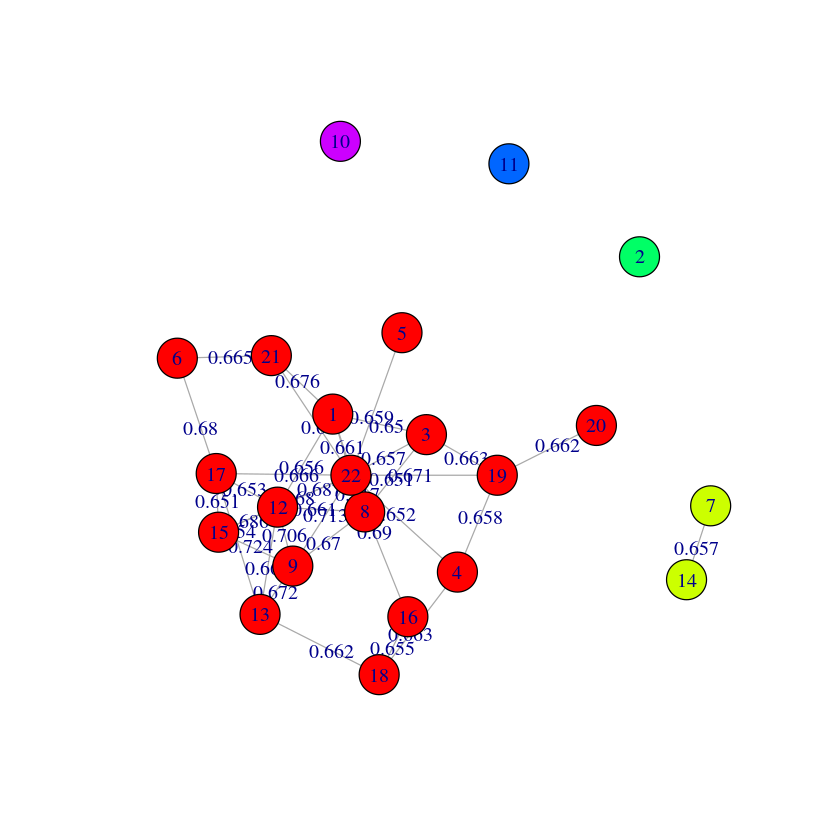

In [165]:
plot.igraph(J, vertex.color=high_order_colors[high_order_go_assignments_], edge.label=E(J)$weight)

In [166]:
F <- graph_from_adjacency_matrix(high_order_edges, mode = "undirected", weighted = T)

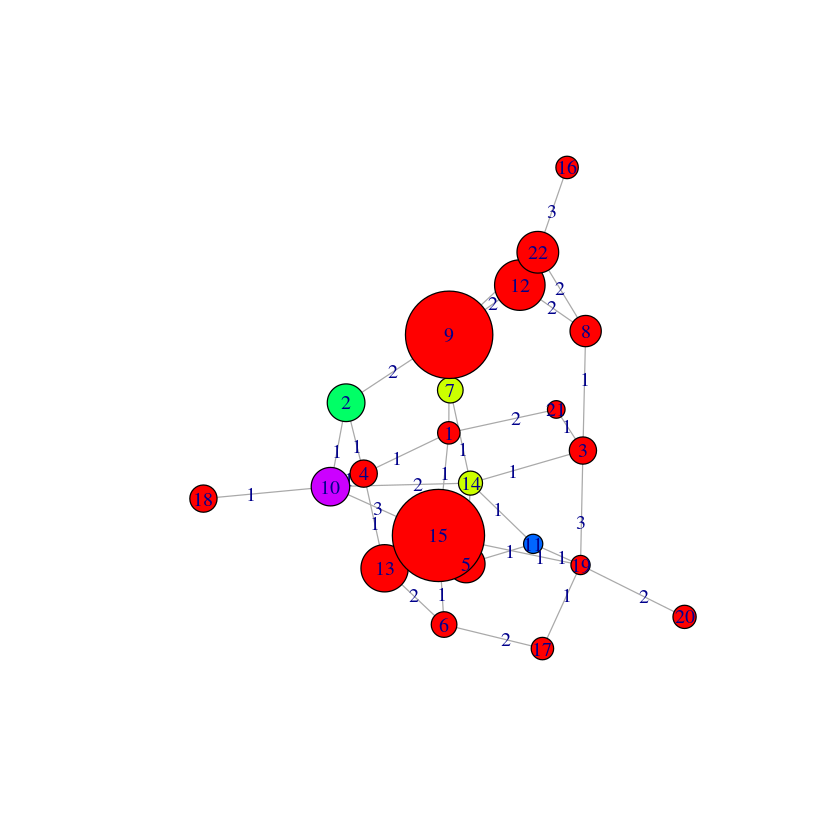

In [173]:
plot.igraph(F, vertex.size=lengths(high_order_orf_communities)/3, 
            vertex.color=high_order_colors[high_order_go_assignments_], edge.label=E(F)$weight)

In [168]:
high_order_orf_communities[[9]]

311       312       313       314       315       316       317       318 
"YMR280C" "YOR047C" "YPR103W" "YKL038W" "YOR302W" "YFR049W" "YLR305C" "YOR358W" 
      319      3110      3111      3112      1341      1342      1343      1344 
"YBL021C" "YGL237C" "YLR114C" "YGR146C" "YBL046W" "YNL201C" "YFL056C" "YPR115W" 
     1391      1392      1393      1394      1395       151       152       153 
"YJR122W" "YHR158C" "YLR452C" "YGR238C" "YAL024C" "YFR033C" "YNL236W" "YDR054C" 
      154       155       156       157       158       901       902       903 
"YGR117C" "YJR034W" "YGR046W" "YKL012W" "YGR013W" "YHR140W" "YDL012C" "YFR047C" 
      904       905       906       907      1241      1242      1243      1244 
"YHR032W" "YLL046C" "YIL172C" "YDR151C" "YOR355W" "YHL046C" "YDR207C" "YLR305C" 
     1245      1246      1247      1248      1249      1431      1432      1433 
"YGL150C" "YDL002C" "YER092W" "YLR052W" "YGL220W" "YNL091W" "YNL164C" "YPL229W" 
     1434      1435       771       772       773       774       775       776 
"YKL075C" "YHR169W" "YDL134C" "YMR028W" "YDL188C" "YPR040W" "YNR032W" "YBR187W" 
      941       942       943       944       945      1761      1762      1763 
"YGL229C" "YOR062C" "YJL178C" "YJL211C" "YBR196C" "YJL013C" "YAL040C" "YOR026W" 
     1764       451       452       453       454       455       456        51 
"YGR188C" "YLR447C" "YOR332W" "YDR277C" "YOR028C" "YJR141W" "YER143W" "YJL203W" 
       52        53        54        55        56        57        58        59 
"YHR114W" "YLR112W" "YJL086C" "YJL180C" "YER096W" "YGR110W" "YFL018C" "YDL217C" 
      510       511       512       513       971       972       973       974 
"YCR035C" "YDR529C" "YDR422C" "YOR059C" "YJR097W" "YNL092W" "YML037C" "YOR329C" 
      975       976       977      1351      1352      1353      1354      1355 
"YJR093C" "YPR107C" "YBR205W" "YGL214W" "YLR435W" "YER131W" "YLL027W" "YGL189C" 
     1921      1922      1923      1924      1925      1926      1927      1928 
"YBR241C" "YIR033W" "YNL111C" "YCR068W" "YDR434W" "YNR030W" "YPL053C" "YBR029C" 
     1929     19210     19211     19212     19213 
"YDR284C" "YPR071W" "YPL176C" "YDR086C" "YGL225W"